In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

import matplotlib.pyplot as plt
import seaborn as sns

from vendi_score import vendi

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# define compounds in scope as a dictionary

scope_compounds_dict = {
    "8a": "EN300-20027",
    "8b": "EN300-18989",
    "8c": "AJC001",
    "8d": "EN300-13206",
    "8e": "EN300-16958",
    "8f": "EN300-20348",
    "8g": "EN300-62688",
    "8h": "AJC002",
    "8i": "EN300-43319",
    "8j": "EN300-61954",
    "8k": "EN300-39266",
    "8l": "AJC003",
    "8m": "EN300-49064",
    "8n": "EN300-18739",
    "8o": "EN300-77249",
    "8p": "EN300-12163",
    "8q": "EN300-19571",
    "8r": "EN300-20439",
    "8s": "EN300-75686",
    "8t": "AJC004",
    "8u": "EN300-41781",
    "8v": "EN300-21136",
    "8w": "EN300-7578636",
    "8x": "EN300-19392",
    "8y": "EN300-20438",
    "12": "AJC005"
}

In [3]:
# load in a file which has the smiles strings in

df = pd.read_csv('aqme_ready.csv', index_col=0)

In [4]:
scope_labels = [label for label in scope_compounds_dict.keys() if scope_compounds_dict[label] in df.index]
print(scope_labels)

['8a', '8b', '8c', '8d', '8e', '8f', '8g', '8h', '8i', '8j', '8k', '8l', '8m', '8n', '8o', '8p', '8q', '8r', '8s', '8t', '8u', '8v', '8w', '8x', '8y', '12']


In [5]:
# get the smiles strings for the compounds in the scope

scope_smiles = [df.loc[enamine_id, 'SMILES'] for enamine_id in scope_compounds_dict.values() if enamine_id in df.index]

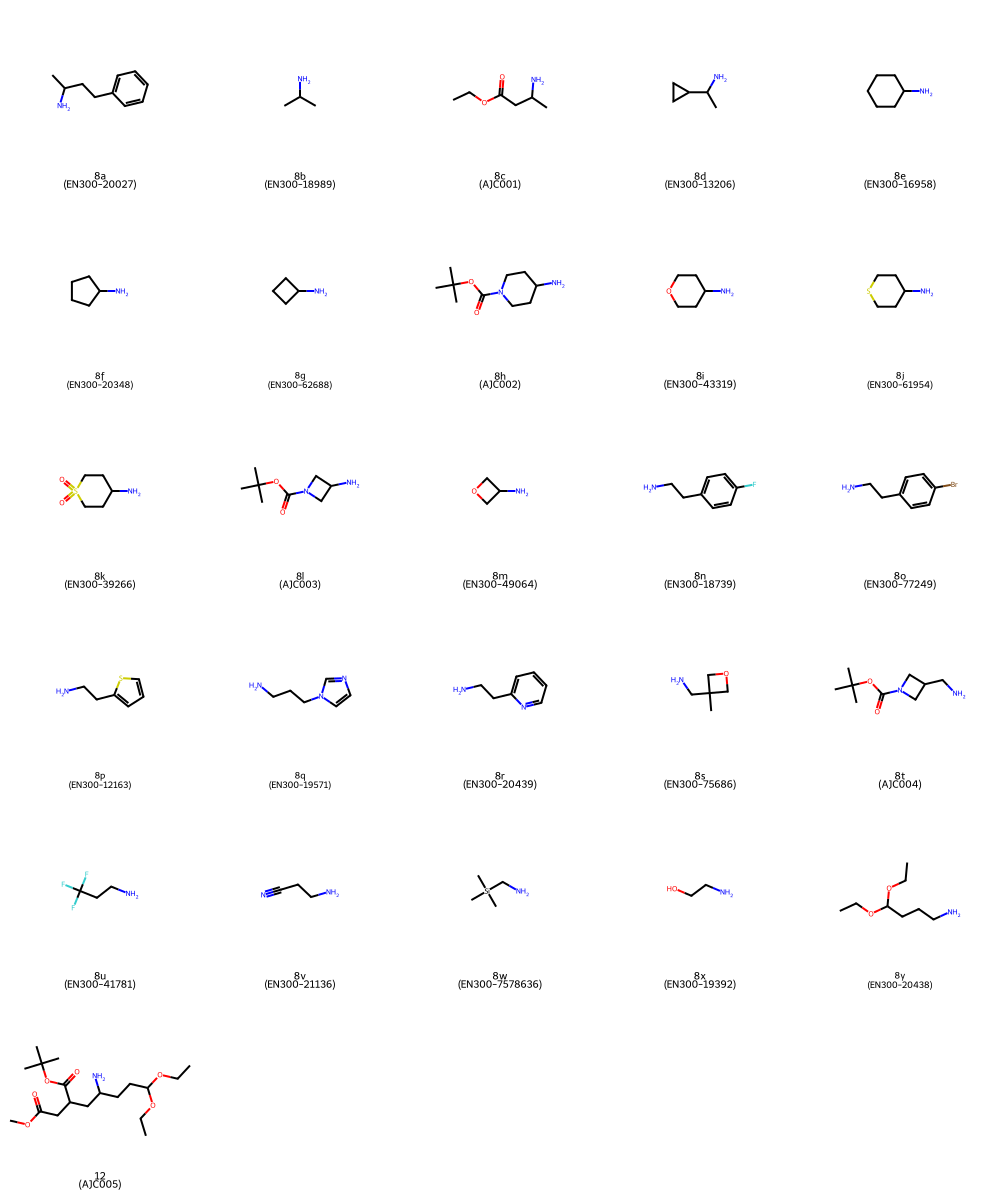

In [7]:
def draw_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    return mol

scope_images = [draw_molecule(smiles) for smiles in scope_smiles]

# display the scope compounds
scope_labels = list(scope_compounds_dict.keys())
enamine_ids = list(scope_compounds_dict.values())
labels = [f"{label}\n({enamine_id})" for label, enamine_id in zip(scope_labels, enamine_ids) if enamine_id in df.index]
Draw.MolsToGridImage(scope_images, molsPerRow=5, subImgSize=(200, 200), legends=labels)


In [8]:
def tanimoto_similarity(query_smiles, all_smiles, bits=1024):
    results = []
    query_mol = Chem.MolFromSmiles(query_smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=bits)
    query_fp = mfpgen.GetFingerprint(query_mol)

    for mol in all_smiles:
        fp = mfpgen.GetFingerprint(Chem.MolFromSmiles(mol))
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)

        result_entry = {
            'Query SMILES': query_smiles,
            'Data SMILES': mol,
            'Tanimoto Similarity': similarity
        }
        results.append(result_entry)

    df = pd.DataFrame(results)
    return df

In [9]:
# calculate the vendi score using the tanimoto similarity based on the fingerprints
# first for 1024 bit fingerprints

tanimoto_matrix = np.zeros((len(scope_labels), len(scope_labels)))

for i, smile1 in enumerate(scope_smiles):
    for j, smile2 in enumerate(scope_smiles):
        tanimoto_matrix[i, j] = tanimoto_similarity(smile1, [smile2], bits=1024)['Tanimoto Similarity'].values[0]

In [10]:
print(len(scope_labels))

26


<Axes: >

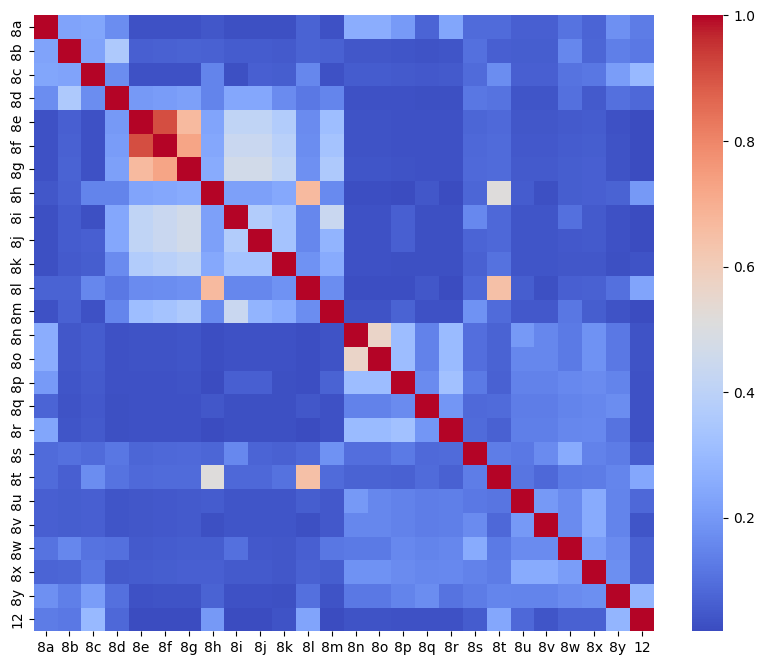

In [20]:
# visualise the similarity matrix

plt.figure(figsize=(10, 8))
sns.heatmap(tanimoto_matrix, xticklabels=scope_labels, yticklabels=scope_labels, cmap='coolwarm', annot=False, fmt=".2f")

In [12]:
# determine the vendi score

vendi_score = vendi.score_K(tanimoto_matrix)
print(f"Vendi Score (1024 bit fingerprints): {vendi_score}")

Vendi Score (1024 bit fingerprints): 19.33015923552764


In [13]:
# for 2048 bit fingerprints

tanimoto_matrix = np.zeros((len(scope_smiles), len(scope_smiles)))

for i, smile1 in enumerate(scope_smiles):
    for j, smile2 in enumerate(scope_smiles):
        tanimoto_matrix[i, j] = tanimoto_similarity(smile1, [smile2], bits=2048)['Tanimoto Similarity'].values[0]

<Axes: >

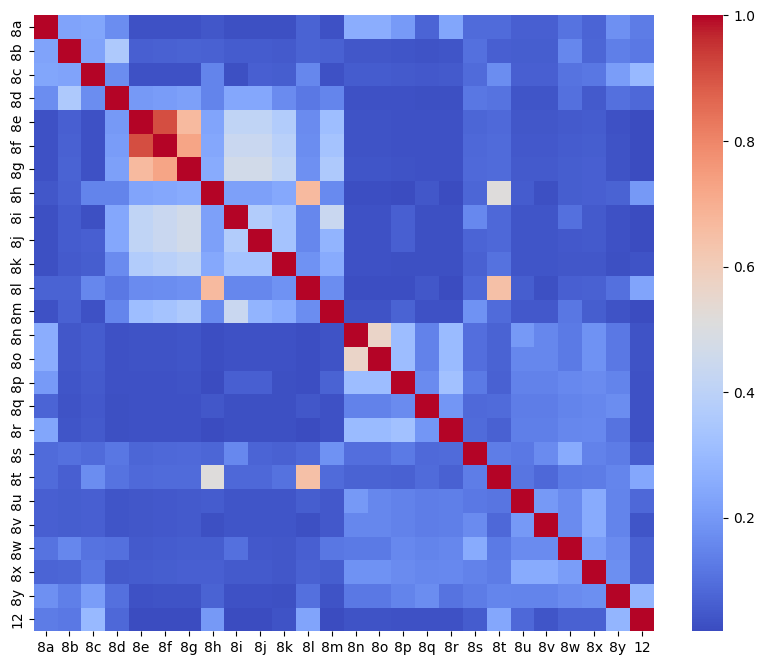

In [21]:
# visualise the similarity matrix

plt.figure(figsize=(10, 8))
sns.heatmap(tanimoto_matrix, xticklabels=scope_labels, yticklabels=scope_labels, cmap='coolwarm', annot=False, fmt=".2f")

In [15]:
# determine the vendi score

vendi_score = vendi.score_K(tanimoto_matrix)
print(f"Vendi Score (2048 bit fingerprints): {vendi_score}")

Vendi Score (2048 bit fingerprints): 19.522120760641904
